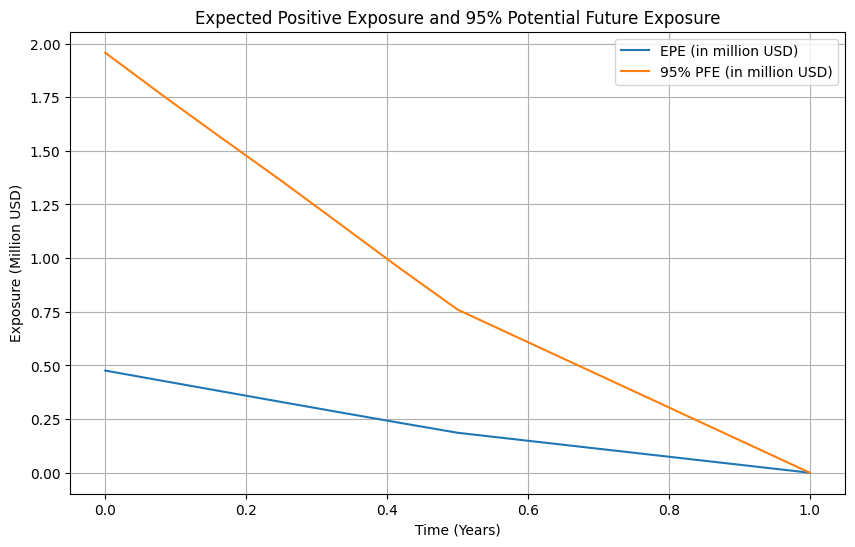

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
n_paths = 10000
n_steps = 12
T = 1.0  # 1 year
dt = T / n_steps
time_grid = np.linspace(0, T, n_steps + 1)

# Hull-White model parameters
a = 0.1      # mean reversion
sigma = 0.01 # volatility
r0 = 0.02    # initial short rate (flat yield curve)

# Swap parameters
notional = 100e6
fixed_rate = 0.02  # 2%
payment_dates = np.linspace(0.5, 1.0, 2)  # Semiannual
delta = 0.5  # accrual period

def simulate_short_rates():
    rates = np.zeros((n_paths, n_steps + 1))
    rates[:, 0] = r0
    for t in range(1, n_steps + 1):
        dr = a * (r0 - rates[:, t - 1]) * dt + sigma * np.sqrt(dt) * np.random.randn(n_paths)
        rates[:, t] = rates[:, t - 1] + dr
    return rates

def discount_factor(rates, t_index):
    return np.exp(-np.cumsum(rates[:, :t_index + 1] * dt, axis=1)[:, -1])

def swap_value(rates, t_index):
    # Calculate value of future floating - fixed cash flows
    t = time_grid[t_index]
    swap_values = np.zeros(n_paths)

    for pd in payment_dates:
        if pd >= t:
            tau = pd - t
            df_idx = int(pd / dt)
            if df_idx >= len(time_grid):
                df_idx = -1
            df = discount_factor(rates, df_idx)
            forward_rate = rates[:, df_idx]
            float_leg = forward_rate * tau * notional
            fixed_leg = fixed_rate * tau * notional
            swap_values += (float_leg - fixed_leg) * df
    return swap_values

# Simulate short rates
short_rates = simulate_short_rates()

# Compute exposures
exposures = np.zeros((n_paths, n_steps + 1))

for t in range(n_steps + 1):
    val = swap_value(short_rates, t)
    exposures[:, t] = np.maximum(val, 0)

# Expected Positive Exposure (EPE)
EPE = exposures.mean(axis=0)

# Potential Future Exposure (PFE) at 95%
PFE = np.percentile(exposures, 95, axis=0)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(time_grid, EPE / 1e6, label='EPE (in million USD)')
plt.plot(time_grid, PFE / 1e6, label='95% PFE (in million USD)')
plt.xlabel("Time (Years)")
plt.ylabel("Exposure (Million USD)")
plt.title("Expected Positive Exposure and 95% Potential Future Exposure")
plt.legend()
plt.grid(True)
plt.show()
